In [1]:
#!pip install EnsemblePursuit
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [4]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39_total/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


(18795, 50)
None
(642,)


(array([ 26., 176., 218., 141.,  64.,  15.,   0.,   1.,   0.,   1.]),
 array([ 1.1378856 ,  3.49444619,  5.85100679,  8.20756738, 10.56412798,
        12.92068857, 15.27724917, 17.63380976, 19.99037036, 22.34693095,
        24.70349155]),
 <a list of 10 Patch objects>)

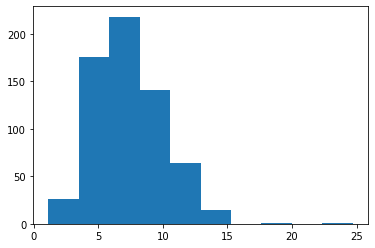

In [6]:
#Select stim ensemble, make weights for stim ens
U=np.load('U.npy')
print(print(U.shape))
stim_ens_inds=np.nonzero(U[:,13])[0]
print(stim_ens_inds.shape)
stim_k=7.5
stim_theta=1.0
stim_weights=np.random.gamma(shape=stim_k,scale=stim_theta,size=(stim_ens_inds.shape[0],))
plt.hist(stim_weights)

(463,)


(array([228., 114.,  63.,  31.,  13.,   8.,   2.,   0.,   3.,   1.]),
 array([2.87081784e-03, 1.33743264e+00, 2.67199446e+00, 4.00655628e+00,
        5.34111810e+00, 6.67567992e+00, 8.01024174e+00, 9.34480356e+00,
        1.06793654e+01, 1.20139272e+01, 1.33484890e+01]),
 <a list of 10 Patch objects>)

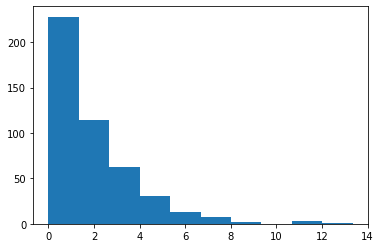

In [7]:
#Select beh ensemble, make weights for stim_ens
beh_ens_inds=np.nonzero(U[:,8])[0]
print(beh_ens_inds.shape)
beh_k=1.0
beh_theta=2.0
beh_weights=np.random.gamma(shape=beh_k,scale=beh_theta,size=(beh_ens_inds.shape[0],))
plt.hist(beh_weights)

In [8]:
weights=np.hstack((stim_weights,beh_weights))
print(weights.shape)

(1105,)


In [9]:
stim_inp=S[stim_ens_inds]
beh_imp=S[beh_ens_inds]
input_patterns=np.vstack((stim_inp,beh_imp))

In [10]:
del spks

In [11]:
del S

In [12]:
print(input_patterns.shape)

(1105, 30560)


In [109]:
N_E=1

r_0 = 1.0
r_max = 100.0 #maybe should set to more realistic value (e.g. =20)?

dt = .001

alpha = 0.01
BCM_lambda = 0.9

theta_BCM = 1.0

theta_BCM = np.ones(N_E)*1.0

BCM_target = 2.0
theta_BCM_dt = .001

W_max = 1.0

def update_theta_BCM(x,theta_BCM):
    x_arr = x.reshape(x.size,)
    theta_BCM += theta_BCM_dt*((x_arr[:N_E]/BCM_target)*x_arr[:N_E] - theta_BCM)

    return theta_BCM

def update_weights(_x,_W,_theta_BCM,input_patterns):

    _W[:N_E] += alpha*_x*np.dot(input_patterns,(input_patterns-_theta_BCM))

    # bounding weights to be positive
    _W[:N_E] = _W[:N_E]*(0.5 * (np.sign(_W[:N_E]) + 1))

    # bounding weights below max value
    _W[_W>W_max] = W_max
    
    print('W',_W)
    # no self-connections
    #np.fill_diagonal(_W,0.0)
    return W

def update_state_sliding_threshold(x,W,H,theta_BCM,input_patterns):
    H=0
    print(W)
    print(input_patterns)
    print(np.dot(W,input_patterns))
    x += dt*(-1*x + np.dot(W,input_patterns) + H)

    # only allow positive firing rates
    x = x*(0.5 * (np.sign(x) + 1))

    W = update_weights(x,W,theta_BCM,input_patterns)

    theta_BCM = update_theta_BCM(x,theta_BCM)

    return x,W,theta_BCM

def update_rates(x):
    #rates = x
    x[x<=0] = r_0*np.tanh(x[x<=0]/r_0)
    x[x>0] = (r_max-r_0)*np.tanh(x[x>0]/(r_max-r_0))

    return x

def update_state(x,W,input_patterns,BCM):
    H=0
    x += dt*(-1*x + np.dot(W,input_patterns))
    #x += dt*(-1*x +W*update_rates(x) + H)
    # only allow positive firing rates
    x = x*(0.5 * (np.sign(x) + 1))

    W = update_weights(x,W,BCM,input_patterns)

    return x,W

In [110]:
def run_net_plastic(x,W,input_patterns,T=1000,N_sample=N_E):
    pop_rate = []
    theta_BCM=1.0
    #ext_OU = prep_net_run(T)
    T=100

    for i in range(T):
        H=0
        #H_noisy = H+ext_OU[i]+OU_drive[i]
        H_noisy=0
        x,W = update_state(x,W,input_patterns[:,i],theta_BCM)
        print(x)

        x,W,theta_BCM = update_state_sliding_threshold(x,W,H,theta_BCM,input_patterns)


In [107]:
x=np.zeros((1,))
W=weights
print(W.shape)
print(input_patterns.shape)
print(np.dot(W,input_patterns))
run_net_plastic(x,W,input_patterns)

(1105,)
(1105, 30560)
[49593.25927913 49735.77287415 47560.94275578 ... 24527.45925243
 39441.28395279 21963.39076373]
[49.59325928]
None
[[  34.19176    740.78375    738.2173    ...    0.           0.
     0.       ]
 [  37.413887    36.545643   375.73035   ...    2.2846625    0.
     0.       ]
 [  64.83908      0.           0.        ... 1362.1385     670.392
   370.91995  ]
 ...
 [   0.           0.           0.        ...    0.           0.
     0.       ]
 [  16.559952     0.           0.        ...    0.           5.1093636
     0.       ]
 [   0.          13.184659     0.        ...    0.          22.028135
    20.791363 ]]


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'